<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gaussian-Process-Regression" data-toc-modified-id="Gaussian-Process-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gaussian Process Regression</a></span></li><li><span><a href="#An-exmaple" data-toc-modified-id="An-exmaple-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>An exmaple</a></span></li></ul></div>

# Gaussian Process Regression

In [1]:
import numpy as np

class RBF:
    '''
    kij = exp(-(d(xi, xj))^2/(2 l^2))
    '''
    def __init__(self, length_scale = 1.0, sigma = 1.):
        self.length_scale = length_scale
        self.sigma = 1.
        
    def __call__(self, X, Y=None):
        '''
        (X.shape[0], X.shape[1])
        '''
        if Y is None:
            Y = X
            
        distance2 = np.square(X[:,np.newaxis,:] - Y[np.newaxis,:,:]).sum(axis=2)
        distance2 /= 2*self.length_scale**2
        K = np.exp(-distance2)
        K *= self.sigma
        return K
        
def Zero(X):
    return np.zeros(X.shape[0])
        
class GaussianProcessRegressor:
    
    def __init__(self, m = None, kernel=None, alpha=1E-10):
            
        self.kernel = kernel          
        self.m = m
        self.alpha = alpha
        
    def fit(self, X, y):
        '''
        X should be 2D matrix
        If you have only 1 feature use shape of (N,1)
        '''
        
        self.kernel_ = self.kernel            
        if self.kernel_ is None:
            self.kernel_ = RBF(length_scale = 1.0, sigma = 1.0)
            
        self.m_ = self.m
        if self.m_ is None:
            self.m_ = Zero
            
        X = np.array(X, dtype=np.float_)
        y = np.array(y, dtype=np.float_)
        
        y = y - self.m_(X)
        KXX = self.kernel_(X, X)
        
            
        if self.alpha != 0:
            KXX += self.alpha * np.eye(X.shape[0])

        invKXX = np.linalg.inv(KXX)
        weights = invKXX.dot(y)
        self.invKXX = invKXX
        self.coef_ = weights
            
        
        self.X = X
        self.y = y
        self.y_m = y
        self.KXX = KXX
        
        
    def predict(self, X, return_std=False):
        '''
        X should be 2D matrix
        If you have only 1 feature use shape of (N,1)
        '''
        X = np.array(X, dtype=np.float_)
        
        Y = X
        X = self.X
        KYX = self.kernel_(Y, X)
                    
        f = KYX.dot(self.coef_) + self.m_(Y)

        if not return_std:
            return f

        invKXX =  self.invKXX        
        KYY = self.kernel_(Y, Y) + self.alpha * np.eye(Y.shape[0])
        KXY =  KYX.T
        KYY_post = KYY - KYX.dot( invKXX.dot(KXY) )
        return f, np.sqrt(np.maximum(0, np.diagonal(KYY_post)))
        
        

# An exmaple

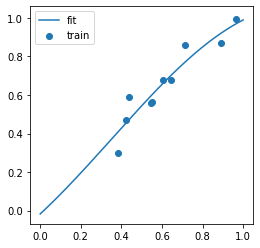

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
X_train = np.random.rand(10).reshape(-1,1)
y_train = X_train[:,0] + 0.1*np.random.randn(10)
X_plt = np.linspace(0,1,1000)

gpr=GaussianProcessRegressor(kernel=RBF(-1,1), alpha=1E-1**2)
gpr.fit(X_train, y_train)
y_plt = gpr.predict(X_plt.reshape(-1,1))

plt.figure(figsize=(4,4))
plt.scatter(X_train, y_train, label="train")
plt.plot(X_plt, y_plt, label="fit")
plt.legend()
plt.show()